# Introduction
Our task is to determine the sentiment of a sentence. For this purpose we have 3 training sets from Amazon, IMDB and Yelp reviews that are labeled as positive or negative. Hence our goal is to do binary classification using NLP!

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import gensim

#  Data loading

In [2]:
# Using Amazon and IMDB sets as training and Yelp as testing set
# Files can be downloaded from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
train_docs = ['/home/fabi/UPM/DL/sentiment labelled sentences/amazon_cells_labelled.txt', '/home/fabi/UPM/DL/sentiment labelled sentences/imdb_labelled.txt']
test_docs = ['/home/fabi/UPM/DL/sentiment labelled sentences/yelp_labelled.txt']

train_corpus = []
train_labels = []
test_corpus = []
test_labels = []

for doc in train_docs:
    with open(doc) as fp:
        for line in fp:
            # Split lines into text and label
            values = line.split("\t")
            train_corpus.append(values[0].rstrip()) # remove trailing tabs or new lines
            train_labels.append(values[1].rstrip()) # remove trailing tabs or new lines
        
for doc in test_docs:
    with open(doc) as fp:
        for line in fp:
            # Split lines into text and label
            values = line.split("\t")
            test_corpus.append(values[0].rstrip()) # remove trailing tabs or new lines
            test_labels.append(values[1].rstrip()) # remove trailing tabs or new lines
        
print "There are {} labeled sentences in our training set " \
    "and {} in our testing set.".format(len(train_corpus), len(test_corpus))

There are 2000 labeled sentences in our training set and 1000 in our testing set.


# Bag of Words approach

In Bag of Words we want to create a large matrix that represents each sentence in a simple format. The sentences are stored in the rows of the matrix in a one-hot-encoded format. The columns are representing all possible words that we have learned from our initial dataset, the cells then show how often each word is represented in each sentence.

First we start by extracting the features from our training set, to learn a dictionary and we transform our testing set into the same dictionary format. In the second step we train a classifier to predict the sentiment of each sentence and verify our results using the test corpus

### Feature extractor

In [3]:
vectorizer = CountVectorizer(min_df=1)

In [4]:
X = vectorizer.fit_transform(train_corpus)

In [5]:
print "Number of unique words: {}".format(len(vectorizer.get_feature_names()))

Number of unique words: 4100


In [6]:
print "{} sentences and {} unique words create a matrix of the shape {}.".format(
    len(train_corpus),
    len(vectorizer.get_feature_names()),
    X.toarray().shape
    )
# Create the bag of words matrix
train_BoW = X.toarray()
test_BoW = vectorizer.transform(test_corpus)

2000 sentences and 4100 unique words create a matrix of the shape (2000, 4100).


## Classifier
Next we train a binary classifier to predict whether each sentence is positive or negative. Sklearn provides a fast implementation. Using the fit_intercept attribute we can add a bias term to our data.

The model returns 1 for positive and 0 for negative sentiment.

In [7]:
def train_lr(train_X, train_labels, test_X, test_labels):
    # Instantiate a Logistic Regression model and runs on 4 cores in parallel
    model = LogisticRegression(fit_intercept=True, n_jobs=4)
    model.fit(train_X, train_labels)
    result = model.score(test_X, test_labels)
    print "Accuracy achieved: {}".format(result)
    return model

In [8]:
model = train_lr(train_BoW, train_labels, test_BoW, test_labels)

Accuracy achieved: 0.761


In [9]:
# Print examples
for i in range(55, 75, 5):
    print test_corpus[i]
    print "This sentence was predict to be ",
    print "positive" if (model.predict(test_BoW[i])[0] == '1') else "negative"

Loved it...friendly servers, great food, wonderful and imaginative menu.
This sentence was predict to be  positive
At least think to refill my water before I struggle to wave you over for 10 minutes.
This sentence was predict to be  positive
Great food and service, huge portions and they give a military discount.
This sentence was predict to be  positive
The deal included 5 tastings and 2 drinks, and Jeff went above and beyond what we expected.
This sentence was predict to be  negative


## N-grams
So far the model only takes single words into account. But in natural language neighboring words often have a strong correlation between each other. We can increase the number of words per gram from 1 to a number n < sentence length.

In [10]:
# Using 1-grams and 2-grams 
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)
X_bigram = bigram_vectorizer.fit_transform(train_corpus)
train_BoW = X_bigram.toarray()
test_BoW = bigram_vectorizer.transform(test_corpus)

model = train_lr(train_BoW, train_labels, test_BoW, test_labels)

Accuracy achieved: 0.778


In [11]:
# Using 1-grams, 2-grams and 3-grams
bigram_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                    token_pattern=r'\b\w+\b', min_df=1)
X_bigram = bigram_vectorizer.fit_transform(train_corpus)
train_BoW = X_bigram.toarray()
test_BoW = bigram_vectorizer.transform(test_corpus)

model = train_lr(train_BoW, train_labels, test_BoW, test_labels)

Accuracy achieved: 0.779


In [12]:
# Best accuracy using 1-4 grams
bigram_vectorizer = CountVectorizer(ngram_range=(1, 4),
                                    token_pattern=r'\b\w+\b', min_df=1)
X_bigram = bigram_vectorizer.fit_transform(train_corpus)
train_BoW = X_bigram.toarray()
test_BoW = bigram_vectorizer.transform(test_corpus)

model = train_lr(train_BoW, train_labels, test_BoW, test_labels)

Accuracy achieved: 0.784


In [13]:
# Compute RoC curve
fpr, tpr, thresholds = roc_curve(np.array(test_labels).astype(np.float32), model.decision_function(test_BoW.toarray()).astype(np.float32))
roc_auc = auc(fpr, tpr)

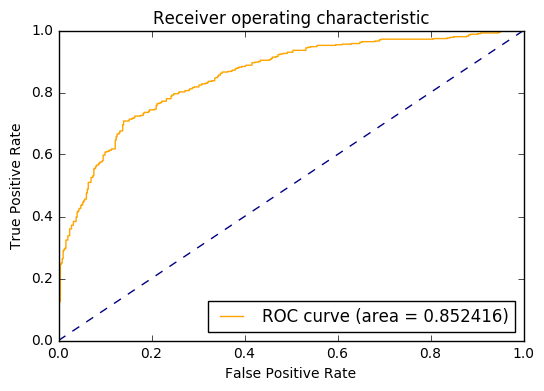

In [14]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc), color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Cross validation
So far we have only trained the model on two datasets and tested on the third one.
To get a better understanding of how well our model works we can also test against the other two by using k-folds cross validation!

In [15]:
# Reorder the datasets
inter = train_corpus[0:1000]
train_corpus[0:1000] = test_corpus[0:1000]
test_corpus[0:1000] = inter[:]

In [16]:
# Best accuracy using 1-2 grams
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)
X_bigram = bigram_vectorizer.fit_transform(train_corpus)
train_BoW = X_bigram.toarray()
test_BoW = bigram_vectorizer.transform(test_corpus)

model = train_lr(train_BoW, train_labels, test_BoW, test_labels)

Accuracy achieved: 0.516


In [17]:
# Reorder the datasets
inter = train_corpus[1000:2000]
train_corpus[1000:2000] = test_corpus[0:1000]
test_corpus[0:1000] = inter[:]

In [18]:
# Best accuracy using 1-2 grams
bigram_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                    token_pattern=r'\b\w+\b', min_df=1)
X_bigram = bigram_vectorizer.fit_transform(train_corpus)
train_BoW = X_bigram.toarray()
test_BoW = bigram_vectorizer.transform(test_corpus)

model = train_lr(train_BoW, train_labels, test_BoW, test_labels)

Accuracy achieved: 0.489


It looks like the initial split was by far the best!

# Word2Vec

Word2Vec is a popular implementation of the skip-gram model. It returns a probability distribution over all words in our dictionary, for lying within a window of some other word. This means if we select the word 'Madrid' from a sentence, and a window size of 4, word2vec will return the probability distribution over all words to lie within 4 words to the left and 4 words to the right of 'Madrid' in our sentence. Hence 'Real',  'Atletico' and 'Spain' will have a high probability while 'tree', 'mother' and 'universe' should have a low probability.

In [19]:
# First we will load a pre-trained version of Word2Vec
# Model can be downloaded from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
model = gensim.models.KeyedVectors.load_word2vec_format('/media/large/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

In [20]:
# Investigate the model a bit
print model.similarity('house', 'mansion')
print model.similarity('house', 'garage')
print model.similarity('house', 'canada')
print model.most_similar('house')

0.605819178355
0.547117918203
0.0622883051074
[(u'houses', 0.7072390913963318), (u'bungalow', 0.6878559589385986), (u'apartment', 0.6628996729850769), (u'bedroom', 0.6496936678886414), (u'townhouse', 0.6384080052375793), (u'residence', 0.6198420524597168), (u'mansion', 0.6058192253112793), (u'farmhouse', 0.5857570171356201), (u'duplex', 0.5757936239242554), (u'appartment', 0.5690325498580933)]


This time we have to separate the words also when loading the data, so we can lookup their word2vec representations

In [21]:

# Using Amazon and IMDB sets as training and Yelp as testing set
train_docs = ['/home/fabi/UPM/DL/sentiment labelled sentences/amazon_cells_labelled.txt', '/home/fabi/UPM/DL/sentiment labelled sentences/imdb_labelled.txt']
test_docs = ['/home/fabi/UPM/DL/sentiment labelled sentences/yelp_labelled.txt']

train_corpus = []
train_labels = []
test_corpus = []
test_labels = []

for doc in train_docs:
    with open(doc) as fp:
        for line in fp:
            # Split lines into text and label
            values = line.split("\t")
            train_corpus.append(np.array(values[0].rstrip().split())) # remove trailing tabs or new lines
            train_labels.append(values[1].rstrip()) # remove trailing tabs or new lines
        
for doc in test_docs:
    with open(doc) as fp:
        for line in fp:
            # Split lines into text and label
            values = line.split("\t")
            test_corpus.append(np.array(values[0].rstrip().split())) # remove trailing tabs or new lines
            test_labels.append(values[1].rstrip()) # remove trailing tabs or new lines
        
print "There are {} labeled sentences in our training set " \
    "and {} in our testing set.".format(len(train_corpus), len(test_corpus))

There are 2000 labeled sentences in our training set and 1000 in our testing set.


In [22]:
print train_corpus[0]

['So' 'there' 'is' 'no' 'way' 'for' 'me' 'to' 'plug' 'it' 'in' 'here' 'in'
 'the' 'US' 'unless' 'I' 'go' 'by' 'a' 'converter.']


Now we need to find the vector representation of each word, and then aggregate them by the sentence. In the pre-trained word2vec each word is represented as a 300-dimensional vector. Thus, we need to lookup the vector for each word in each sentence in the word2vec dictionary. Then we will take the average over all words within a sentence to get a paragraph vector. Alternatively we could do a clustering over the sentence or use doc2vec.

In [23]:
train_word_vectors = []
test_word_vectors = []
for sentence in train_corpus:
    word_vectors = np.zeros((sentence.shape[0], 300))
    for idx, word in enumerate(sentence):
        # Some words do not appear in the pretrained word2vec
        try:
            word_vectors[idx] = model[word]
        except KeyError:
            pass
    # take bag of mean to get paragraph vector
    paragraph_vector = np.mean(word_vectors, axis=0)
    train_word_vectors.append(paragraph_vector)
    
for sentence in test_corpus:
    word_vectors = np.zeros((sentence.shape[0], 300))
    for idx, word in enumerate(sentence):
        # Some words do not appear in the pretrained word2vec
        try:
            word_vectors[idx] = model[word]
        except KeyError:
            pass
    # take bag of mean to get paragraph vector
    paragraph_vector = np.mean(word_vectors, axis=0)
    test_word_vectors.append(paragraph_vector)    

In [24]:
model = train_lr(np.array(train_word_vectors), np.array(train_labels), np.array(test_word_vectors), np.array(test_labels))

Accuracy achieved: 0.752


In [25]:
# Compute RoC curve
fpr, tpr, thresholds = roc_curve(np.array(test_labels).astype(np.float32), model.decision_function(np.array(test_word_vectors)).astype(np.float32))
roc_auc = auc(fpr, tpr)

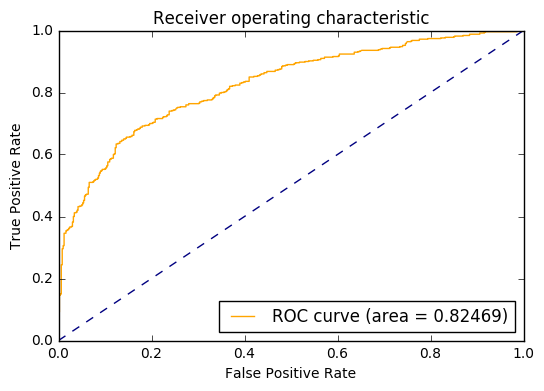

In [26]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc), color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The pretrained Word2Vec cannot beat the simple bag of words approach. This might be due to the small datasize that does not require the capacity of this large word2vec. Also it turns out that the bag of words approach works better without removing the stopwords. In word2vec they are removed which could cause the model to perform a little worse on this simple task. Doc2Vec could improve the score of word2vec as well.